This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### Autoencoder /  Classify 22 Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
#!pip install ipython-autotime

%load_ext autotime

time: 539 µs (started: 2021-12-07 03:39:30 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.8 ms (started: 2021-12-07 03:39:30 +00:00)


### Load pretrained autoencoder.

In [5]:
# Create autoencoder model (skeleton) for loading pretrained weights.

def create_autoencoder():
    # Define the model
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #2nd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #3rd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))    

    #1st deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    
    #2nd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))

    #3rd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))    
    
    model.add(Conv2D(3,(3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    
    return model

time: 5.44 ms (started: 2021-12-07 03:39:30 +00:00)


In [6]:
# Load pretrained autoencoder weights.

checkpoint_path = "./model/autoencoder.ckpt"
autoencoder = create_autoencoder()
autoencoder.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9

time: 1.74 s (started: 2021-12-07 03:39:30 +00:00)


### The below code is for creating training data tfrecord and idx file from images. (We do not use the below code in this jupyter notebook since we import tfrecords directly.)

```python
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

from itertools import islice
from subprocess import call

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

#def _float_feature(value):
#    """Returns a float_list from a float / double."""
#    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    if type(value) != list:
        value = [value]
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

# Create a dictionary with relevant features.

def image_example(image_string, label):
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def gen_tfrecord_idx(tfrecord_file, dict_label, tfrecord_idx):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename, label in dict_label.items():
            fname = "./image/" + filename
            image_string = open(fname, 'rb').read()
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())

    tfrecord2idx_script = "tfrecord2idx"

    if not os.path.isfile(tfrecord_idx):
        call([tfrecord2idx_script, tfrecord_file, tfrecord_idx])


#--------------------------------------------
# VALID DATA: Load labels, check headers, check data shape.

df_label_valid = pd.read_csv('label/label_22_emo_valid.csv')
print("valid columns:", df_label_valid.columns)
print("valid shape:", df_label_valid.shape)

# Place labels into a dictionary.

dict_label_valid = {}
for idx, row in df_label_valid.iterrows():
    dict_label_valid[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_valid)

#--------------------------------------------
# Create VALID tfrecord & idx files from jpg images.

tfrecord_file_valid = './tfrecords/22_emo_valid.tfrecords'
tfrecord_idx_valid = './tfrecords/22_emo_valid.idx'

gen_tfrecord_idx(tfrecord_file_valid, dict_label_valid, tfrecord_idx_valid)

#--------------------------------------------
# TRAIN DATA: Load labels, check headers, check data shape.

df_label_train = pd.read_csv('label/label_22_emo_train.csv')
print("train columns:", df_label_train.columns)
print("train shape:", df_label_train.shape)

# Place labels into a dictionary.

dict_label_train = {}
for idx, row in df_label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_train)

#--------------------------------------------
# Create TRAIN tfrecord & idx files from jpg images.

tfrecord_file_train = './tfrecords/22_emo_train.tfrecords'
tfrecord_idx_train = './tfrecords/22_emo_train.idx'

gen_tfrecord_idx(tfrecord_file_train, dict_label_train, tfrecord_idx_train) 

#--------------------------------------------
# TEST DATA: Load labels, check headers, check data shape.

df_label_test = pd.read_csv('label/label_22_emo_test.csv')
print("test columns:", df_label_test.columns)
print("test shape:", df_label_test.shape)

# Place labels into a dictionary.

dict_label_test = {}
for idx, row in df_label_test.iterrows():
    dict_label_test[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_test)

#-------------------------------------------
# Create TEST tfrecord & idx files from jpg images.

tfrecord_file_test = './tfrecords/22_emo_test.tfrecords'
tfrecord_idx_test = './tfrecords/22_emo_test.idx'

gen_tfrecord_idx(tfrecord_file_test, dict_label_test, tfrecord_idx_test) 

# OUTPUT
# valid columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
#       'disgusted'],
#      dtype='object')
# valid shape: (1980, 22)
# train columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
#       'disgusted'],
#      dtype='object')
# train shape: (15840, 22)
# test columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
#       'disgusted'],
#      dtype='object')
# test shape: (1980, 22)
```  

### Load label data.

In [7]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('label/label_22_emo.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv('label/label_22_emo_valid.csv')
label_train = pd.read_csv('label/label_22_emo_train.csv')
label_test = pd.read_csv('label/label_22_emo_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
       'disgusted'],
      dtype='object')
(19800, 24)
LABELS= ['moved', 'fearful', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 22
TRAIN_DATA_SIZE: 15840
VALID_DATA_SIZE: 1980
TEST_DATA_SIZE: 1980
time: 74.8 ms (started: 2021-12-07 03:39:32 +00:00)


### Calculate class weights.

In [8]:
dict_label_train = {}
for idx, row in label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_train)

15840

time: 3.31 s (started: 2021-12-07 03:39:32 +00:00)


In [9]:
y_train_ls = list(dict_label_train.values())
#y_train_ls

time: 637 µs (started: 2021-12-07 03:39:35 +00:00)


In [10]:
y_train_ints = [y.index(1) for y in y_train_ls]
#y_train_ints

time: 27.7 ms (started: 2021-12-07 03:39:35 +00:00)


In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train_ints),
                                                  y_train_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 2.88,
 1: 3.2142857142857144,
 2: 0.3314917127071823,
 3: 0.11865524060646011,
 4: 0.9461235216819974,
 5: 3.0,
 6: 5.625,
 7: 0.9809264305177112,
 8: 6.050420168067227,
 9: 12.203389830508474,
 10: 0.46632124352331605,
 11: 0.5286343612334802,
 12: 1.769041769041769,
 13: 32.72727272727273,
 14: 4.444444444444445,
 15: 1.978021978021978,
 16: 2.1114369501466275,
 17: 1.894736842105263,
 18: 5.142857142857143,
 19: 5.853658536585366,
 20: 4.8979591836734695,
 21: 7.741935483870968}

time: 283 ms (started: 2021-12-07 03:39:36 +00:00)


In [12]:
class_weights

array([ 2.88      ,  3.21428571,  0.33149171,  0.11865524,  0.94612352,
        3.        ,  5.625     ,  0.98092643,  6.05042017, 12.20338983,
        0.46632124,  0.52863436,  1.76904177, 32.72727273,  4.44444444,
        1.97802198,  2.11143695,  1.89473684,  5.14285714,  5.85365854,
        4.89795918,  7.74193548])

time: 2.66 ms (started: 2021-12-07 03:39:36 +00:00)


In [13]:
n_samples = len(dict_label_train)
n_classes = len(set(y_train_ints))

time: 3.68 ms (started: 2021-12-07 03:39:36 +00:00)


In [14]:
multiplier = 3
adjusted_cw = class_weights / n_classes * multiplier
adjusted_cw

array([0.39272727, 0.43831169, 0.04520342, 0.01618026, 0.12901684,
       0.40909091, 0.76704545, 0.1337627 , 0.8250573 , 1.66409861,
       0.06358926, 0.0720865 , 0.24123297, 4.46280992, 0.60606061,
       0.26973027, 0.28792322, 0.25837321, 0.7012987 , 0.79822616,
       0.66790353, 1.05571848])

time: 4.42 ms (started: 2021-12-07 03:39:36 +00:00)


In [15]:
log_weights = n_samples / (n_classes * np.log(np.bincount(y_train_ints)))
sum_weights = sum(log_weights)
sum_weights
custom_class_weights = log_weights / sum_weights
custom_class_weights

array([0.04463074, 0.0455364 , 0.03207262, 0.02828986, 0.03714251,
       0.04496317, 0.05078841, 0.03734585, 0.0515632 , 0.06043523,
       0.0335634 , 0.03414671, 0.04101091, 0.07972291, 0.0484368 ,
       0.04178743, 0.04225512, 0.04148481, 0.04986741, 0.05120895,
       0.04937987, 0.05436768])

time: 6.33 ms (started: 2021-12-07 03:39:36 +00:00)


In [16]:
custom_class_weights += adjusted_cw
custom_class_weights

array([0.43735802, 0.48384809, 0.07727604, 0.04447012, 0.16615935,
       0.45405408, 0.81783386, 0.17110854, 0.8766205 , 1.72453384,
       0.09715266, 0.10623322, 0.28224388, 4.54253283, 0.65449741,
       0.3115177 , 0.33017834, 0.29985802, 0.75116611, 0.84943511,
       0.71728339, 1.11008615])

time: 3.31 ms (started: 2021-12-07 03:39:36 +00:00)


In [17]:
class_weight_dict = dict(enumerate(custom_class_weights))
class_weight_dict

{0: 0.43735801571868704,
 1: 0.48384809272560536,
 2: 0.07727603752877807,
 3: 0.04447012394919416,
 4: 0.16615934894029083,
 5: 0.45405407973744055,
 6: 0.8178338647074261,
 7: 0.17110854124487898,
 8: 0.876620496202587,
 9: 1.7245338407756894,
 10: 0.09715266034914719,
 11: 0.10623321618311929,
 12: 0.28224387957200436,
 13: 4.542532828599931,
 14: 0.6544974094004671,
 15: 0.31151769951307157,
 16: 0.3301783420621469,
 17: 0.29985802035019415,
 18: 0.7511661101655956,
 19: 0.8494351130651482,
 20: 0.7172833931995184,
 21: 1.1100861516206217}

time: 3.97 ms (started: 2021-12-07 03:39:36 +00:00)


### Define training pipeline.

In [18]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = ['./tfrecords/22_emo_train.tfrecords'],
             index_path = ['./tfrecords/22_emo_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 88.1 ms (started: 2021-12-07 03:39:36 +00:00)


### Define validation pipeline.

In [19]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = ['./tfrecords/22_emo_valid.tfrecords'],
             index_path = ['./tfrecords/22_emo_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.72 ms (started: 2021-12-07 03:39:36 +00:00)


### Train autoencoder model for classifying 22 emotions.

In [20]:
if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)
    
    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 22))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)        

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)            
      
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.softmax
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 22
        
        inputs = keras.Input(shape=(64, 64, 3))
        x = autoencoder(inputs, training=False)   # Fix autoencoder weights.
        flat = keras.layers.Flatten()(x)
        fc1 = keras.layers.Dense(number_of_classes, activation='relu',
                             kernel_initializer=initializer)(flat)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)        
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # To save the model weights, uncomment the below code.        
        #checkpoint_path = "./model/cp_clf_24_emo.ckpt"
        #checkpoint_dir = os.path.dirname(checkpoint_path)
        #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
        #                                         save_weights_only=True,
        #                                         verbose=1)

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          callbacks=[es_callback])    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         48003     
_________________________________________________________________
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 22)                270358    
_________________________________________________________________
dropout (Dropout)            (None, 22)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                506       
Total params: 318,867
Trainable params: 318,867
Non-trainable params: 0
_______________________________________________________

247/247 [==============================] - 4s 17ms/step - loss: 1.8401 - accuracy: 0.4647 - val_loss: 1.6694 - val_accuracy: 0.5182
Epoch 106/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.8454 - accuracy: 0.4647 - val_loss: 1.6619 - val_accuracy: 0.5193
Epoch 107/1000
247/247 [==============================] - 4s 15ms/step - loss: 1.8407 - accuracy: 0.4694 - val_loss: 1.6632 - val_accuracy: 0.5161
Epoch 108/1000
247/247 [==============================] - 4s 15ms/step - loss: 1.8420 - accuracy: 0.4679 - val_loss: 1.6570 - val_accuracy: 0.5167
Epoch 109/1000
247/247 [==============================] - 4s 15ms/step - loss: 1.8377 - accuracy: 0.4616 - val_loss: 1.6598 - val_accuracy: 0.5198
Epoch 110/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.8345 - accuracy: 0.4657 - val_loss: 1.6610 - val_accuracy: 0.5214
Epoch 111/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.8349 - accuracy: 0.4653 - val_loss: 1.6540 - val_acc

Epoch 161/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.7405 - accuracy: 0.4852 - val_loss: 1.5784 - val_accuracy: 0.5365
Epoch 162/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.7400 - accuracy: 0.4845 - val_loss: 1.5791 - val_accuracy: 0.5375
Epoch 163/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.7420 - accuracy: 0.4846 - val_loss: 1.5792 - val_accuracy: 0.5375
Epoch 164/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.7399 - accuracy: 0.4836 - val_loss: 1.5766 - val_accuracy: 0.5365
Epoch 165/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.7362 - accuracy: 0.4868 - val_loss: 1.5740 - val_accuracy: 0.5437
Epoch 166/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.7381 - accuracy: 0.4822 - val_loss: 1.5703 - val_accuracy: 0.5417
Epoch 167/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.7306 - accuracy: 0.4841 - val_loss: 1

Epoch 217/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.6678 - accuracy: 0.5005 - val_loss: 1.5157 - val_accuracy: 0.5536
Epoch 218/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.6791 - accuracy: 0.4951 - val_loss: 1.5142 - val_accuracy: 0.5547
Epoch 219/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6703 - accuracy: 0.4965 - val_loss: 1.5173 - val_accuracy: 0.5542
Epoch 220/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6690 - accuracy: 0.4970 - val_loss: 1.5169 - val_accuracy: 0.5531
Epoch 221/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.6852 - accuracy: 0.4885 - val_loss: 1.5136 - val_accuracy: 0.5557
Epoch 222/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6681 - accuracy: 0.4943 - val_loss: 1.5146 - val_accuracy: 0.5536
Epoch 223/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6632 - accuracy: 0.4945 - val_loss: 1

Epoch 273/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6262 - accuracy: 0.5085 - val_loss: 1.4694 - val_accuracy: 0.5724
Epoch 274/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6186 - accuracy: 0.5094 - val_loss: 1.4681 - val_accuracy: 0.5714
Epoch 275/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.6187 - accuracy: 0.5072 - val_loss: 1.4681 - val_accuracy: 0.5703
Epoch 276/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6201 - accuracy: 0.5116 - val_loss: 1.4664 - val_accuracy: 0.5714
Epoch 277/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6235 - accuracy: 0.5052 - val_loss: 1.4642 - val_accuracy: 0.5724
Epoch 278/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6213 - accuracy: 0.5076 - val_loss: 1.4640 - val_accuracy: 0.5750
Epoch 279/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.6315 - accuracy: 0.5083 - val_loss: 1

Epoch 329/1000
247/247 [==============================] - 4s 15ms/step - loss: 1.5914 - accuracy: 0.5141 - val_loss: 1.4351 - val_accuracy: 0.5870
Epoch 330/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5967 - accuracy: 0.5098 - val_loss: 1.4362 - val_accuracy: 0.5828
Epoch 331/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5825 - accuracy: 0.5179 - val_loss: 1.4333 - val_accuracy: 0.5849
Epoch 332/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5816 - accuracy: 0.5169 - val_loss: 1.4340 - val_accuracy: 0.5875
Epoch 333/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5829 - accuracy: 0.5182 - val_loss: 1.4327 - val_accuracy: 0.5854
Epoch 334/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.5872 - accuracy: 0.5152 - val_loss: 1.4320 - val_accuracy: 0.5885
Epoch 335/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5883 - accuracy: 0.5174 - val_loss: 1

Epoch 385/1000
247/247 [==============================] - 4s 15ms/step - loss: 1.5540 - accuracy: 0.5280 - val_loss: 1.4122 - val_accuracy: 0.5906
Epoch 386/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5592 - accuracy: 0.5236 - val_loss: 1.4117 - val_accuracy: 0.5901
Epoch 387/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5626 - accuracy: 0.5233 - val_loss: 1.4126 - val_accuracy: 0.5896
Epoch 388/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5579 - accuracy: 0.5260 - val_loss: 1.4109 - val_accuracy: 0.5901
Epoch 389/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.5544 - accuracy: 0.5243 - val_loss: 1.4097 - val_accuracy: 0.5932
Epoch 390/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.5566 - accuracy: 0.5252 - val_loss: 1.4089 - val_accuracy: 0.5906
Epoch 391/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5501 - accuracy: 0.5262 - val_loss: 1

Epoch 441/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5465 - accuracy: 0.5300 - val_loss: 1.3957 - val_accuracy: 0.5911
Epoch 442/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5395 - accuracy: 0.5251 - val_loss: 1.3953 - val_accuracy: 0.5932
Epoch 443/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5274 - accuracy: 0.5325 - val_loss: 1.3939 - val_accuracy: 0.5943
Epoch 444/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.5415 - accuracy: 0.5269 - val_loss: 1.3954 - val_accuracy: 0.5932
Epoch 445/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5374 - accuracy: 0.5297 - val_loss: 1.3944 - val_accuracy: 0.5917
Epoch 446/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5289 - accuracy: 0.5333 - val_loss: 1.3944 - val_accuracy: 0.5922
Epoch 447/1000
247/247 [==============================] - 4s 17ms/step - loss: 1.5361 - accuracy: 0.5275 - val_loss: 1

Epoch 497/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5286 - accuracy: 0.5302 - val_loss: 1.3835 - val_accuracy: 0.5927
Epoch 498/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5192 - accuracy: 0.5352 - val_loss: 1.3827 - val_accuracy: 0.5932
Epoch 499/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5203 - accuracy: 0.5354 - val_loss: 1.3812 - val_accuracy: 0.5938
Epoch 500/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5306 - accuracy: 0.5299 - val_loss: 1.3818 - val_accuracy: 0.5938
Epoch 501/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5241 - accuracy: 0.5328 - val_loss: 1.3821 - val_accuracy: 0.5938
Epoch 502/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5219 - accuracy: 0.5330 - val_loss: 1.3812 - val_accuracy: 0.5938
Epoch 503/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5193 - accuracy: 0.5345 - val_loss: 1

Epoch 553/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5147 - accuracy: 0.5364 - val_loss: 1.3743 - val_accuracy: 0.5964
Epoch 554/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5199 - accuracy: 0.5344 - val_loss: 1.3734 - val_accuracy: 0.5958
Epoch 555/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5200 - accuracy: 0.5342 - val_loss: 1.3740 - val_accuracy: 0.5958
Epoch 556/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5156 - accuracy: 0.5325 - val_loss: 1.3741 - val_accuracy: 0.5943
Epoch 557/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5190 - accuracy: 0.5358 - val_loss: 1.3739 - val_accuracy: 0.5953
Epoch 558/1000
247/247 [==============================] - 4s 16ms/step - loss: 1.5123 - accuracy: 0.5338 - val_loss: 1.3739 - val_accuracy: 0.5943
Epoch 559/1000
247/247 [==============================] - 4s 15ms/step - loss: 1.5159 - accuracy: 0.5323 - val_loss: 1

In [21]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 620 µs (started: 2021-12-07 04:19:12 +00:00)


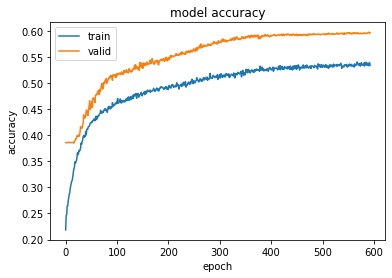

time: 183 ms (started: 2021-12-07 04:19:12 +00:00)


In [22]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

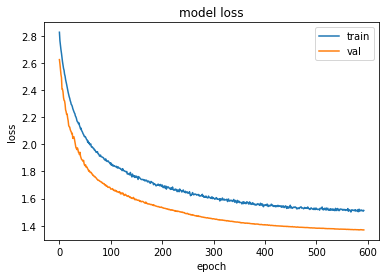

time: 147 ms (started: 2021-12-07 04:19:12 +00:00)


In [23]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [24]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = ['./tfrecords/22_emo_test.tfrecords'],
             index_path = ['./tfrecords/22_emo_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.78 ms (started: 2021-12-07 04:19:12 +00:00)


### Check test data accuracy.

In [25]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset shapes: ((1, 64, 64, 3), (1, 22)), types: (tf.float32, tf.int64)>
1980/1980 [==============================] - 14s 7ms/step - loss: 1.3598 - accuracy: 0.6056
Test accuracy: 0.605555534362793
A test output from the last layer: [1.7047711e-03 2.3703121e-03 3.8183294e-02 8.5587436e-01 1.5203939e-02
 2.8329745e-03 1.8829972e-03 1.5169433e-02 3.1423834e-04 2.5982002e-04
 2.1248456e-02 2.8918145e-02 3.1961915e-03 8.4121457e-05 4.1340594e-04
 5.0050225e-03 1.7394791e-03 2.3028131e-03 1.1126851e-03 4.8126662e-04
 6.1869412e-04 1.0835781e-03]
Index of the maximum value: 3
Label: angry
time: 14.3 s (started: 2021-12-07 04:19:12 +00:00)


In [26]:
predictions

array([[1.70477107e-03, 2.37031211e-03, 3.81832942e-02, 8.55874360e-01,
        1.52039388e-02, 2.83297454e-03, 1.88299723e-03, 1.51694333e-02,
        3.14238336e-04, 2.59820023e-04, 2.12484561e-02, 2.89181452e-02,
        3.19619151e-03, 8.41214569e-05, 4.13405942e-04, 5.00502251e-03,
        1.73947914e-03, 2.30281311e-03, 1.11268507e-03, 4.81266616e-04,
        6.18694117e-04, 1.08357810e-03],
       [3.09654069e-03, 6.10392820e-03, 5.25930859e-02, 7.57590413e-01,
        1.80098191e-02, 1.15296915e-02, 4.30605141e-03, 4.13289070e-02,
        2.36830441e-03, 1.31730479e-03, 2.91621909e-02, 1.90128051e-02,
        4.50542429e-03, 6.01099513e-04, 1.72452512e-03, 1.82870049e-02,
        1.05295833e-02, 1.05698872e-02, 2.96391454e-03, 1.70315173e-03,
        1.39250455e-03, 1.30391656e-03],
       [5.87955723e-03, 7.52678793e-03, 3.66319390e-03, 6.25203013e-01,
        1.27172694e-01, 9.29253455e-03, 9.69510153e-03, 4.68576960e-02,
        5.72439888e-03, 1.07225054e-03, 3.58503289e-03

time: 4.09 ms (started: 2021-12-07 04:19:27 +00:00)


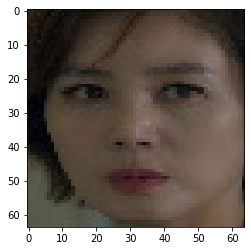

time: 209 ms (started: 2021-12-07 04:19:27 +00:00)


In [27]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [28]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 22), dtype=int64, numpy=array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

time: 2.5 ms (started: 2021-12-07 04:19:27 +00:00)


In [29]:
data

(<tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
 array([[[[0.19607843, 0.15686275, 0.10588235],
          [0.18431373, 0.14509805, 0.09411765],
          [0.13725491, 0.10588235, 0.05098039],
          ...,
          [0.07058824, 0.0627451 , 0.05098039],
          [0.10588235, 0.09019608, 0.09019608],
          [0.08235294, 0.06666667, 0.06666667]],
 
         [[0.1764706 , 0.13725491, 0.08627451],
          [0.17254902, 0.13333334, 0.08235294],
          [0.12941177, 0.09803922, 0.04313726],
          ...,
          [0.0627451 , 0.05490196, 0.04313726],
          [0.09411765, 0.07843138, 0.07843138],
          [0.09411765, 0.07843138, 0.07843138]],
 
         [[0.18039216, 0.14901961, 0.09411765],
          [0.15686275, 0.1254902 , 0.07058824],
          [0.1254902 , 0.09019608, 0.04705882],
          ...,
          [0.08627451, 0.07843138, 0.06666667],
          [0.09411765, 0.08627451, 0.08235294],
          [0.07450981, 0.06666667, 0.0627451 ]],
 
         ...,
 
         

time: 8.25 ms (started: 2021-12-07 04:19:27 +00:00)


In [30]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

time: 8.05 s (started: 2021-12-07 04:19:27 +00:00)


In [31]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 770 ms (started: 2021-12-07 04:19:35 +00:00)


In [32]:
true_test.shape

(1980, 22)

time: 2.49 ms (started: 2021-12-07 04:19:36 +00:00)


In [33]:
from sklearn.metrics import confusion_matrix

pred_test_ls = []
true_test_ls = []
for (pred, true) in zip(pred_test, true_test):
    pred_test_ls.append(np.argmax(pred))
    true_test_ls.append(np.argmax(true))

cf_matrix_test = confusion_matrix(true_test_ls, pred_test_ls)
cf_matrix_test

array([[  0,   0,   0,  25,   0,   0,   0,   1,   0,   0,   4,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   4,   8,   1,   0,   0,   0,   0,   0,  10,   5,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 193,  69,   0,   0,   0,   1,   0,   0,   6,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  16, 725,   1,   0,   0,   1,   0,   0,   4,  12,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,  69,  14,   0,   0,   2,   0,   0,   1,   8,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   3,  18,   0,   0,   0,   0,   0,   0,   6,   3,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,  12,   1,   0,   0,   0,   0,   0,   1,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,  56,   0,   0,   0,  27,   0,   0,   4,   4,   0,
          0,   0,   0,   0,   0,   0, 

time: 56.5 ms (started: 2021-12-07 04:19:36 +00:00)


Text(123.0, 0.5, 'True')

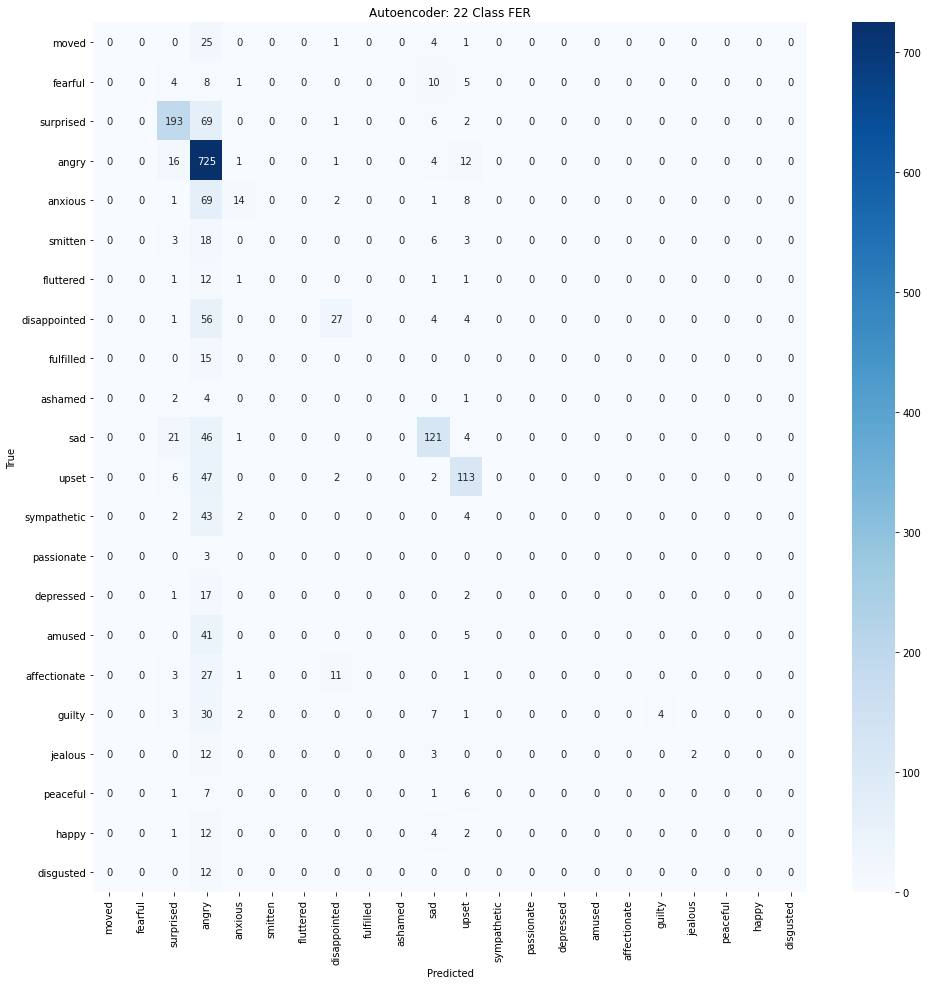

time: 2.33 s (started: 2021-12-07 04:19:36 +00:00)


In [34]:
import seaborn as sns

plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('Autoencoder: 22 Class FER')
plt.xlabel('Predicted')
plt.ylabel('True')

### Check train data accuracy.

In [35]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        loss, acc = clf.evaluate(ds_train, steps=TRAIN_DATA_SIZE)
        print("Train accuracy:", acc)
        #predictions = clf.predict(ds_train.take(1))
        #print("A test output from the last layer:", predictions[0])
        #print("Index of the maximum value:", np.argmax(predictions[0]))
        #print("Label:", LABELS[np.argmax(predictions[0])])

15840/15840 [==============================] - 103s 6ms/step - loss: 1.2386 - accuracy: 0.6258
Train accuracy: 0.6258206963539124
time: 1min 42s (started: 2021-12-07 04:19:38 +00:00)


In [36]:
pred_train = clf.predict(ds_train.take(TRAIN_DATA_SIZE))

time: 1min 1s (started: 2021-12-07 04:21:21 +00:00)


In [37]:
true_train = np.concatenate([y for x, y in ds_train.take(TRAIN_DATA_SIZE)], axis=0)

time: 5.77 s (started: 2021-12-07 04:22:23 +00:00)


In [38]:
true_train.shape

(15840, 22)

time: 2.66 ms (started: 2021-12-07 04:22:28 +00:00)


In [39]:
pred_train_ls = []
true_train_ls = []
for (pred, true) in zip(pred_train, true_train):
    pred_train_ls.append(np.argmax(pred))
    true_train_ls.append(np.argmax(true))

cf_matrix_train = confusion_matrix(true_train_ls, pred_train_ls)
cf_matrix_train

array([[   0,    0,   15,  212,    3,    0,    0,    4,    0,    0,    9,
           7,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   31,   73,    1,    0,    0,    0,    0,    0,   73,
          46,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1585,  528,    0,    0,    0,    2,    0,    0,   35,
          22,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   77, 5907,    8,    0,    0,    7,    0,    0,   29,
          40,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   14,  537,  116,    0,    0,   19,    0,    0,   18,
          57,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   10,  111,    0,    9,    0,   11,    0,    0,   37,
          61,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    7,   85,    4,    0,    0,    6,    0,    0,   22,
           4,    0,    0,    0, 

time: 100 ms (started: 2021-12-07 04:22:28 +00:00)


Text(123.0, 0.5, 'True')

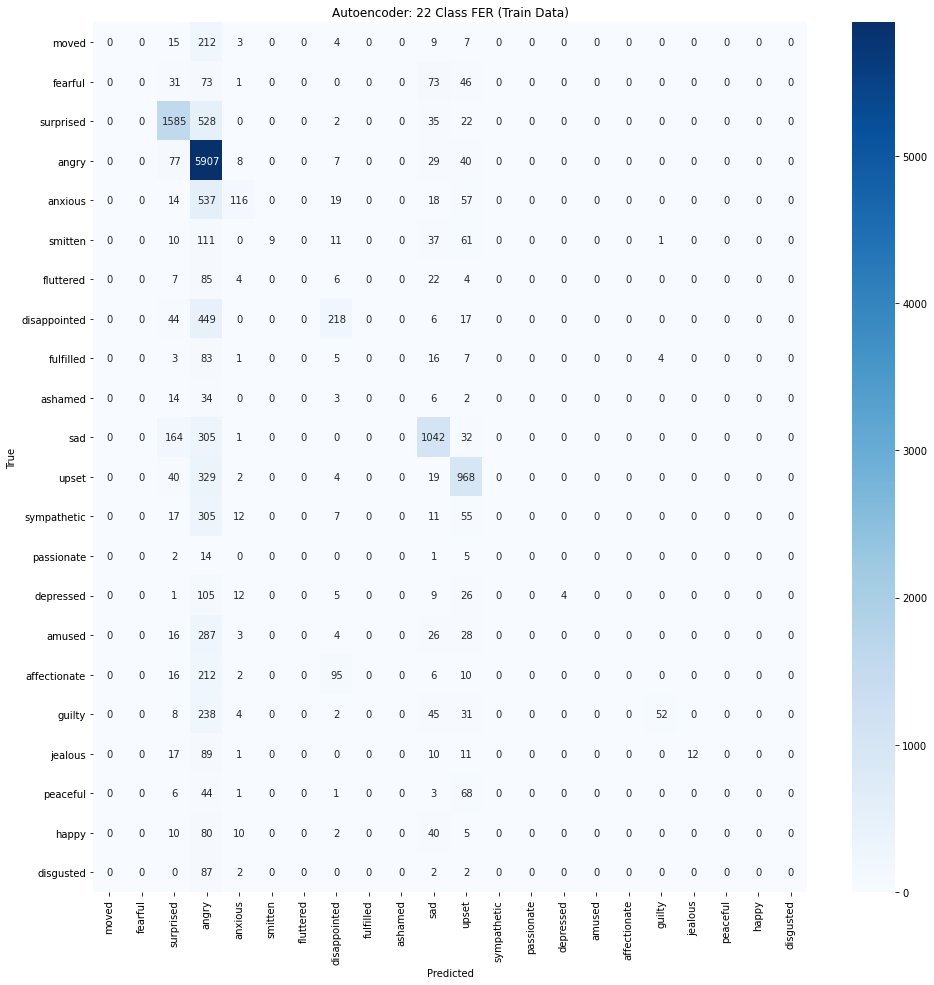

time: 2.29 s (started: 2021-12-07 04:22:29 +00:00)


In [40]:
plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('Autoencoder: 22 Class FER (Train Data)')
plt.xlabel('Predicted')
plt.ylabel('True')